In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
data = pd.read_csv('/mobilejkn_processed.csv')
df = data[['preprocessed', 'label']].dropna()
df.head(10)

,preprocessed,label
0,"['webnya', 'bapuk', 'kurang', 'satset', 'gk', ...",negatif
1,['mantap'],positif
2,"['jauh', 'aplikasi', 'milik', 'perintah', 'mob...",positif
3,"['mau', 'ambil', 'no', 'antre', 'kontrolkuota'...",negatif
4,"['luarbiasa', 'mudah']",positif
5,"['mw', 'daftar', 'tp', 'otp', 'ga', 'kirim']",negatif
6,['mantap'],positif
7,"['aplikasi', 'sangat', 'mudah', 'laku', 'ubah'...",positif
8,"['sangat', 'bantu', 'sekali', 'aplikasi', 'sem...",positif
9,"['sangat', 'susah', 'sekali', 'verifikasi', 'w...",negatif


split data

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])
print('Jumlah data latih:', len(X_train))
print('Jumlah data uji:', len(X_test))
print('Data berhasil di split.')

Jumlah data latih: 8000
Jumlah data uji: 2000
Data berhasil di split.


tf-idf

In [12]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

smote

In [13]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_vec, y_train)
class_distribution = y_train_smote.value_counts()
print(class_distribution)

label
positif    5233
negatif    5233
netral     5233
Name: count, dtype: int64


logrec

In [20]:
model_logrec = LogisticRegression(C=100, max_iter = 1000, class_weight='balanced', penalty='l2')
model_logrec.fit(X_train_smote, y_train_smote)

y_pred_logmodel = model_logrec.predict(X_test_vec)
param_grid_logrec = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
grid_search_logrec = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logrec, cv=5, scoring='accuracy')
grid_search_logrec.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

multinomial nb

In [21]:
model_nb = MultinomialNB(alpha = 0.1)
model_nb.fit(X_train_smote, y_train_smote)

y_pred_nb = model_nb.predict(X_test_vec)

param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, scoring='accuracy')
grid_search_nb.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]},
             scoring='accuracy')

In [27]:
from sklearn.svm import SVC

model_svm = SVC()
model_svm.fit(X_train_smote, y_train_smote)

y_pred_svm = model_svm.predict(X_test_vec)

param_grid_svm = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, refit=True, verbose=3, cv=5)
grid_search_svm.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.930 total time=  22.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.929 total time=  23.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.916 total time=  22.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.911 total time=  20.7s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.917 total time=  21.9s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.886 total time=  19.8s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.876 total time=  20.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.883 total time=  20.3s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.898 total time=  19.5s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.901 total time=  20.7s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.851 total time=  32.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

evaluate

In [28]:
best_log = grid_search_logrec.best_estimator_
y_pred_logmodel = best_log.predict(X_test_vec)
print("===== Kinerja Logistic Regression =====")
print("Parameter Logistic Regression: ", grid_search_logrec.best_params_)
print("Akurasi:", accuracy_score(y_test, y_pred_logmodel))
print("Classification Report: \n", classification_report(y_test, y_pred_logmodel))

best_nb = grid_search_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test_vec)
print("===== Kinerja Naive Bayes =====")
print("Parameter Naive Bayes: ", grid_search_nb.best_params_)
print("Akurasi:", accuracy_score(y_test, y_pred_nb))
print("Classification Report: \n", classification_report(y_test, y_pred_nb))

best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_vec)
print("===== Kinerja SVM =====")
print("Parameter SVM: ", grid_search_svm.best_params_)
print("Akurasi:", accuracy_score(y_test, y_pred_svm))
print("Classification Report: \n", classification_report(y_test, y_pred_svm))

===== Kinerja Logistic Regression =====
Parameter Logistic Regression:  {'C': 100, 'penalty': 'l2'}
Akurasi: 0.89
Classification Report: 
               precision    recall  f1-score   support

     negatif       0.86      0.87      0.86       662
      netral       0.06      0.13      0.08        30
     positif       0.95      0.92      0.93      1308

    accuracy                           0.89      2000
   macro avg       0.62      0.64      0.63      2000
weighted avg       0.91      0.89      0.90      2000

===== Kinerja Naive Bayes =====
Parameter Naive Bayes:  {'alpha': 0.1}
Akurasi: 0.815
Classification Report: 
               precision    recall  f1-score   support

     negatif       0.70      0.91      0.79       662
      netral       0.08      0.27      0.12        30
     positif       0.98      0.78      0.87      1308

    accuracy                           0.81      2000
   macro avg       0.59      0.65      0.59      2000
weighted avg       0.87      0.81      0.83

cm

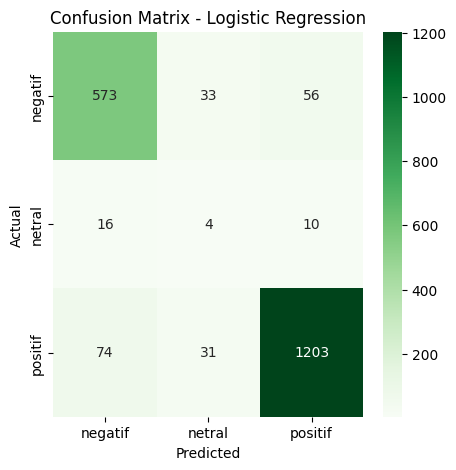

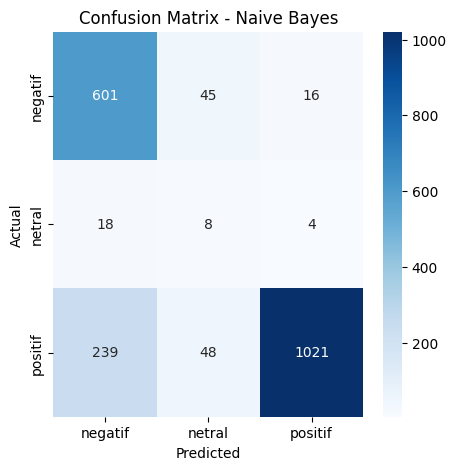

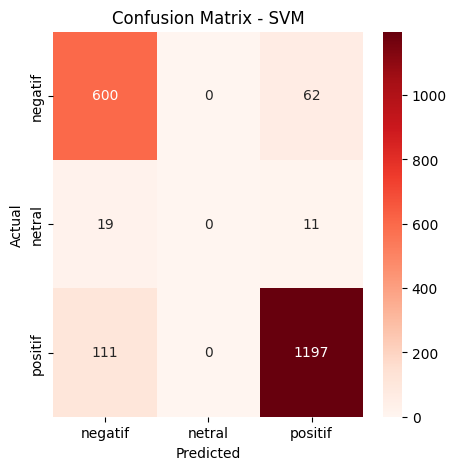

In [29]:
labels = sorted(y_test.unique())
cm_logrec = confusion_matrix(y_test, y_pred_logmodel, labels=labels)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_logrec, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

cm_nb = confusion_matrix(y_test, y_pred_nb, labels=labels)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

cm_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

pie chart

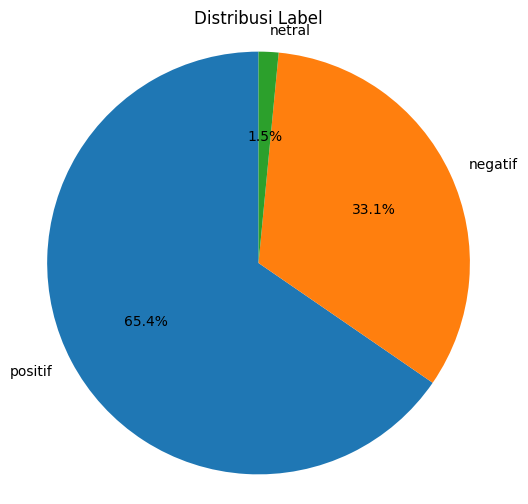

In [30]:
count_label = df['label'].value_counts()
plt.figure(figsize=(6, 6))
colors = ['#ff9999', '#66b3ff', '#99ff99']
plt.pie(count_label, labels=count_label.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Label')
plt.axis('equal')
plt.show()